# Install and import packages

In [26]:
!pip install pyyaml==5.1 'pycocotools>=2.0.1'
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

import torch, torchvision

Processing /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9/PyYAML-5.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.3.1
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [27]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [29]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2, json, os, random
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
import detectron2.data.transforms as T
from pycocotools.coco import COCO

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer



In [ ]:
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
# !unzip balloon_dataset.zip > /dev/null

# Register and visualize dataset

In [30]:
register_coco_instances('building_train', {}, '../input/building-jpg/anno_train.json', '../input/building-jpg/building_jpg/building_jpg/train')
register_coco_instances('building_val', {}, '../input/building-jpg/anno_val.json', '../input/building-jpg/building_jpg/building_jpg/train')

AssertionError: Dataset 'building_train' is already registered!

In [31]:
meta = MetadataCatalog.get('building_train')

In [32]:
d = DatasetCatalog.get('building_train')

[12/01 02:03:19 d2.data.datasets.coco]: Loading ../input/building-jpg/anno_train.json takes 7.41 seconds.
[12/01 02:03:19 d2.data.datasets.coco]: Loaded 4212 images in COCO format from ../input/building-jpg/anno_train.json


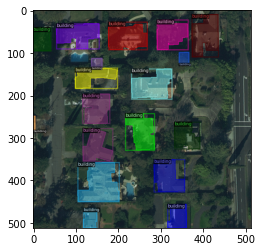

In [33]:
for anno in random.sample(d, 2):
    img = cv2.imread(anno['file_name'])
    visualizer = Visualizer(img, meta)
    out = visualizer.draw_dataset_dict(anno)
#     cv2.imshow(' ', out.get_image())
#     plt.Figure(figsize=(10, 10))a
    plt.imshow(out.get_image()[:, :, ::-1])

# Training

In [34]:
def get_default_optimizer_params(
    model: torch.nn.Module,
    base_lr,
    weight_decay,
    weight_decay_norm,
    bias_lr_factor=1.0,
    weight_decay_bias=None,
):
    if weight_decay_bias is None:
        weight_decay_bias = weight_decay
    """
    Get default param list for optimizer
    """
    norm_module_types = (
        torch.nn.BatchNorm1d,
        torch.nn.BatchNorm2d,
        torch.nn.BatchNorm3d,
        torch.nn.SyncBatchNorm,
        # NaiveSyncBatchNorm inherits from BatchNorm2d
        torch.nn.GroupNorm,
        torch.nn.InstanceNorm1d,
        torch.nn.InstanceNorm2d,
        torch.nn.InstanceNorm3d,
        torch.nn.LayerNorm,
        torch.nn.LocalResponseNorm,
    )
    params: List[Dict[str, Any]] = []
    memo: Set[torch.nn.parameter.Parameter] = set()
    for module in model.modules():
        for key, value in module.named_parameters(recurse=False):
            if not value.requires_grad:
                continue
            # Avoid duplicating parameters
            if value in memo:
                continue
            memo.add(value)

            lr = base_lr
            new_weight_decay = weight_decay
            if isinstance(module, norm_module_types):
                new_weight_decay = weight_decay_norm
            elif key == "bias":
                # NOTE: unlike Detectron v1, we now default BIAS_LR_FACTOR to 1.0
                # and WEIGHT_DECAY_BIAS to WEIGHT_DECAY so that bias optimizer
                # hyperparameters are by default exactly the same as for regular
                # weights.
                lr = base_lr * bias_lr_factor
                new_weight_decay = weight_decay_bias
            params += [{"params": [value], "lr": lr, "weight_decay": new_weight_decay}]

    return params

In [35]:
def build_sem_seg_train_aug(cfg):
    augs = [
        T.Resize((512, 512))
    ]
    augs.append(T.RandomFlip())
    return augs

In [36]:
def build_sem_seg_test_aug(cfg):
    augs = [
        T.Resize((512, 512))
    ]
    return augs

In [37]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_optimizer(cls, cfg, model):
        params = get_default_optimizer_params(
            model,
            base_lr=cfg.SOLVER.BASE_LR,
            weight_decay=cfg.SOLVER.WEIGHT_DECAY,
            weight_decay_norm=cfg.SOLVER.WEIGHT_DECAY_NORM,
            bias_lr_factor=cfg.SOLVER.BIAS_LR_FACTOR,
            weight_decay_bias=cfg.SOLVER.WEIGHT_DECAY_BIAS,
    )
        optimizer = torch.optim.Adam(
            params, cfg.SOLVER.BASE_LR, betas=(cfg.SOLVER.MOMENTUM, 0.999))
        return optimizer
    
#     @classmethod
#     def build_train_loader(cls, cfg):
#         mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
#         return build_detection_train_loader(cfg, mapper=mapper)
    
#     @classmethod
#     def build_test_loader(cls, cfg, dataset_name):
#         return build_detection_test_loader(cfg, dataset_name,
#                                            mapper=DatasetMapper(cfg, is_train=False, augmentations=build_sem_seg_test_aug(cfg)))

In [38]:
cfg = get_cfg()

In [39]:
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

In [40]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('building_train', )
cfg.DATASETS.TEST = ('building_val', )
cfg.TEST.EVAL_PERIOD=100
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001 
cfg.SOLVER.MAX_ITER = 50000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

In [41]:
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
cfg.SOLVER.WARMUP_ITERS = 3000

In [42]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=True)


[12/01 02:03:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[12/01 02:03:29 d2.data.datasets.coco]: Loading ../input/building-jpg/anno_train.json takes 6.18 seconds.
[12/01 02:03:29 d2.data.datasets.coco]: Loaded 4212 images in COCO format from ../input/building-jpg/anno_train.json
[12/01 02:03:30 d2.data.build]: Removed 121 images with no usable annotations. 4091 images left.
[12/01 02:03:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/01 02:03:30 d2.data.build]: Using training sampler TrainingSampler
[12/01 02:03:30 d2.data.common]: Serializing 4091 elements to byte tensors and concatenating them all ...
[12/01 02:03:31 d2.data.common]: Serialized dataset takes 115.18 MiB


In [ ]:
trainer.train()

In [ ]:
print('hello world')

In [46]:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [47]:
cfg.MODEL.WEIGHTS = './output/model_final.pth'  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/01 02:05:24 d2.data.datasets.coco]: Loading ../input/building-jpg/anno_val.json takes 1.72 seconds.
[12/01 02:05:24 d2.data.datasets.coco]: Loaded 1053 images in COCO format from ../input/building-jpg/anno_val.json


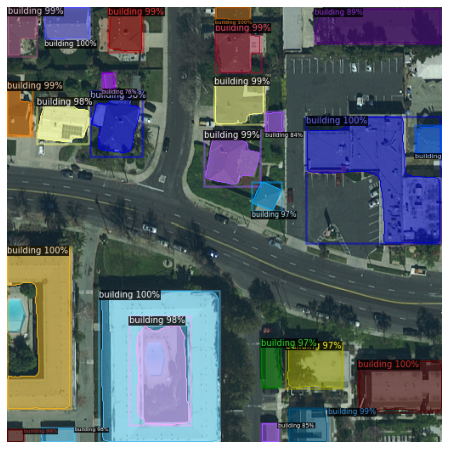

In [51]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get('building_val')
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    v = Visualizer(im[:, :, ::-1],
                   metadata=meta, 
                   scale=1  
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.axis('off')
    ax.imshow(out.get_image())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.axis('off')
ax.imshow(im[:, :, ::-1])

loading annotations into memory...
Done (t=1.71s)
creating index...
index created!


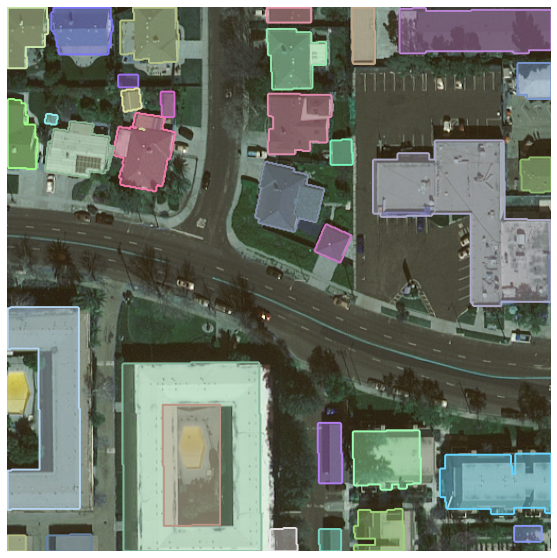

In [52]:
coco = COCO('../input/building-jpg/anno_val.json')
image_data = coco.loadImgs(d['image_id'])[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(im); ax.axis('off')
annotation_ids = coco.getAnnIds(imgIds=image_data['id'], catIds=coco.getCatIds())
annotations = coco.loadAnns(annotation_ids)
coco.showAnns(annotations, draw_bbox=False)

In [53]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [54]:
evaluator = COCOEvaluator('building_val', cfg, False)
val_dl = build_detection_test_loader(cfg, 'building_val')

WARNING [12/01 02:06:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[12/01 02:06:10 d2.data.datasets.coco]: Loading ../input/building-jpg/anno_val.json takes 2.06 seconds.
[12/01 02:06:10 d2.data.datasets.coco]: Loaded 1053 images in COCO format from ../input/building-jpg/anno_val.json
[12/01 02:06:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/01 02:06:10 d2.data.common]: Serializing 1053 elements to byte tensors and concatenating them all ...
[12/01 02:06:10 d2.data.common]: Serialized dataset takes 29.30 MiB


In [55]:
print(inference_on_dataset(trainer.model, val_dl, evaluator))

[12/01 02:06:10 d2.evaluation.evaluator]: Start inference on 1053 images
[12/01 02:06:12 d2.evaluation.evaluator]: Inference done 11/1053. 0.0626 s / img. ETA=0:01:29
[12/01 02:06:17 d2.evaluation.evaluator]: Inference done 62/1053. 0.0688 s / img. ETA=0:01:37
[12/01 02:06:22 d2.evaluation.evaluator]: Inference done 108/1053. 0.0721 s / img. ETA=0:01:37
[12/01 02:06:27 d2.evaluation.evaluator]: Inference done 166/1053. 0.0693 s / img. ETA=0:01:26
[12/01 02:06:32 d2.evaluation.evaluator]: Inference done 223/1053. 0.0681 s / img. ETA=0:01:19
[12/01 02:06:37 d2.evaluation.evaluator]: Inference done 282/1053. 0.0670 s / img. ETA=0:01:11
[12/01 02:06:42 d2.evaluation.evaluator]: Inference done 338/1053. 0.0666 s / img. ETA=0:01:06
[12/01 02:06:47 d2.evaluation.evaluator]: Inference done 395/1053. 0.0662 s / img. ETA=0:01:00
[12/01 02:06:52 d2.evaluation.evaluator]: Inference done 453/1053. 0.0658 s / img. ETA=0:00:54
[12/01 02:06:57 d2.evaluation.evaluator]: Inference done 505/1053. 0.0662 

In [ ]:
import numpy as np
import datetime
import time
from collections import defaultdict
from pycocotools import mask as maskUtils
import copy

"""
This script has been taken (and modified) from :
https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py
"""


class COCOeval:
    # Interface for evaluating detection on the Microsoft COCO dataset.
    #
    # The usage for CocoEval is as follows:
    #  cocoGt=..., cocoDt=...       # load dataset and results
    #  E = CocoEval(cocoGt,cocoDt); # initialize CocoEval object
    #  E.params.recThrs = ...;      # set parameters as desired
    #  E.evaluate();                # run per image evaluation
    #  E.accumulate();              # accumulate per image results
    #  E.summarize();               # display summary metrics of results
    # For example usage see evalDemo.m and http://mscoco.org/.
    #
    # The evaluation parameters are as follows (defaults in brackets):
    #  imgIds     - [all] N img ids to use for evaluation
    #  catIds     - [all] K cat ids to use for evaluation
    #  iouThrs    - [.5:.05:.95] T=10 IoU thresholds for evaluation
    #  recThrs    - [0:.01:1] R=101 recall thresholds for evaluation
    #  areaRng    - [...] A=4 object area ranges for evaluation
    #  maxDets    - [1 10 100] M=3 thresholds on max detections per image
    #  iouType    - ['segm'] set iouType to 'segm', 'bbox' or 'keypoints'
    #  iouType replaced the now DEPRECATED useSegm parameter.
    #  useCats    - [1] if true use category labels for evaluation
    # Note: if useCats=0 category labels are ignored as in proposal scoring.
    # Note: multiple areaRngs [Ax2] and maxDets [Mx1] can be specified.
    #
    # evaluate(): evaluates detections on every image and every category and
    # concats the results into the "evalImgs" with fields:
    #  dtIds      - [1xD] id for each of the D detections (dt)
    #  gtIds      - [1xG] id for each of the G ground truths (gt)
    #  dtMatches  - [TxD] matching gt id at each IoU or 0
    #  gtMatches  - [TxG] matching dt id at each IoU or 0
    #  dtScores   - [1xD] confidence of each dt
    #  gtIgnore   - [1xG] ignore flag for each gt
    #  dtIgnore   - [TxD] ignore flag for each dt at each IoU
    #
    # accumulate(): accumulates the per-image, per-category evaluation
    # results in "evalImgs" into the dictionary "eval" with fields:
    #  params     - parameters used for evaluation
    #  date       - date evaluation was performed
    #  counts     - [T,R,K,A,M] parameter dimensions (see above)
    #  precision  - [TxRxKxAxM] precision for every evaluation setting
    #  recall     - [TxKxAxM] max recall for every evaluation setting
    # Note: precision and recall==-1 for settings with no gt objects.
    #
    # See also coco, mask, pycocoDemo, pycocoEvalDemo
    #
    # Microsoft COCO Toolbox.      version 2.0
    # Data, paper, and tutorials available at:  http://mscoco.org/
    # Code written by Piotr Dollar and Tsung-Yi Lin, 2015.
    # Licensed under the Simplified BSD License [see coco/license.txt]
    def __init__(self, cocoGt=None, cocoDt=None, iouType='segm'):
        '''
        Initialize CocoEval using coco APIs for gt and dt
        :param cocoGt: coco object with ground truth annotations
        :param cocoDt: coco object with detection results
        :return: None
        '''
        if not iouType:
            print('iouType not specified. use default iouType segm')
        self.cocoGt   = cocoGt              # ground truth COCO API
        self.cocoDt   = cocoDt              # detections COCO API
        self.params   = {}                  # evaluation parameters
        self.evalImgs = defaultdict(list)   # per-image per-category evaluation results [KxAxI] elements
        self.eval     = {}                  # accumulated evaluation results
        self._gts = defaultdict(list)       # gt for evaluation
        self._dts = defaultdict(list)       # dt for evaluation
        self.params = Params(iouType=iouType) # parameters
        self._paramsEval = {}               # parameters for evaluation
        self.stats = []                     # result summarization
        self.ious = {}                      # ious between all gts and dts
        if not cocoGt is None:
            self.params.imgIds = sorted(cocoGt.getImgIds())
            self.params.catIds = sorted(cocoGt.getCatIds())


    def _prepare(self):
        '''
        Prepare ._gts and ._dts for evaluation based on params
        :return: None
        '''
        def _toMask(anns, coco):
            # modify ann['segmentation'] by reference
            for ann in anns:
                rle = coco.annToRLE(ann)
                ann['segmentation'] = rle
        p = self.params
        if p.useCats:
            gts=self.cocoGt.loadAnns(self.cocoGt.getAnnIds(imgIds=p.imgIds, catIds=p.catIds))
            dts=self.cocoDt.loadAnns(self.cocoDt.getAnnIds(imgIds=p.imgIds, catIds=p.catIds))
        else:
            gts=self.cocoGt.loadAnns(self.cocoGt.getAnnIds(imgIds=p.imgIds))
            dts=self.cocoDt.loadAnns(self.cocoDt.getAnnIds(imgIds=p.imgIds))

        # convert ground truth to mask if iouType == 'segm'
        if p.iouType == 'segm':
            _toMask(gts, self.cocoGt)
            _toMask(dts, self.cocoDt)
        # set ignore flag
        for gt in gts:
            gt['ignore'] = gt['ignore'] if 'ignore' in gt else 0
            gt['ignore'] = 'iscrowd' in gt and gt['iscrowd']
            if p.iouType == 'keypoints':
                gt['ignore'] = (gt['num_keypoints'] == 0) or gt['ignore']
        self._gts = defaultdict(list)       # gt for evaluation
        self._dts = defaultdict(list)       # dt for evaluation
        for gt in gts:
            self._gts[gt['image_id'], gt['category_id']].append(gt)
        for dt in dts:
            self._dts[dt['image_id'], dt['category_id']].append(dt)
        self.evalImgs = defaultdict(list)   # per-image per-category evaluation results
        self.eval     = {}                  # accumulated evaluation results

    def evaluate(self):
        '''
        Run per image evaluation on given images and store results (a list of dict) in self.evalImgs
        :return: None
        '''
        tic = time.time()
        print('Running per image evaluation...')
        p = self.params
        # add backward compatibility if useSegm is specified in params
        if not p.useSegm is None:
            p.iouType = 'segm' if p.useSegm == 1 else 'bbox'
            print('useSegm (deprecated) is not None. Running {} evaluation'.format(p.iouType))
        print('Evaluate annotation type *{}*'.format(p.iouType))
        p.imgIds = list(np.unique(p.imgIds))
        if p.useCats:
            p.catIds = list(np.unique(p.catIds))
        p.maxDets = sorted(p.maxDets)
        self.params=p

        self._prepare()
        # loop through images, area range, max detection number
        catIds = p.catIds if p.useCats else [-1]

        if p.iouType == 'segm' or p.iouType == 'bbox':
            computeIoU = self.computeIoU
        elif p.iouType == 'keypoints':
            computeIoU = self.computeOks
        self.ious = {(imgId, catId): computeIoU(imgId, catId) \
                        for imgId in p.imgIds
                        for catId in catIds}

        evaluateImg = self.evaluateImg
        maxDet = p.maxDets[-1]
        self.evalImgs = [evaluateImg(imgId, catId, areaRng, maxDet)
                 for catId in catIds
                 for areaRng in p.areaRng
                 for imgId in p.imgIds
             ]
        self._paramsEval = copy.deepcopy(self.params)
        toc = time.time()
        print('DONE (t={:0.2f}s).'.format(toc-tic))

    def computeIoU(self, imgId, catId):
        p = self.params
        if p.useCats:
            gt = self._gts[imgId,catId]
            dt = self._dts[imgId,catId]
        else:
            gt = [_ for cId in p.catIds for _ in self._gts[imgId,cId]]
            dt = [_ for cId in p.catIds for _ in self._dts[imgId,cId]]
        if len(gt) == 0 and len(dt) ==0:
            return []
        inds = np.argsort([-d['score'] for d in dt], kind='mergesort')
        dt = [dt[i] for i in inds]
        if len(dt) > p.maxDets[-1]:
            dt=dt[0:p.maxDets[-1]]

        if p.iouType == 'segm':
            g = [g['segmentation'] for g in gt]
            d = [d['segmentation'] for d in dt]
        elif p.iouType == 'bbox':
            g = [g['bbox'] for g in gt]
            d = [d['bbox'] for d in dt]
        else:
            raise Exception('unknown iouType for iou computation')

        # compute iou between each dt and gt region
        iscrowd = [int(o['iscrowd']) for o in gt]
        ious = maskUtils.iou(d,g,iscrowd)
        return ious

    def computeOks(self, imgId, catId):
        p = self.params
        # dimention here should be Nxm
        gts = self._gts[imgId, catId]
        dts = self._dts[imgId, catId]
        inds = np.argsort([-d['score'] for d in dts], kind='mergesort')
        dts = [dts[i] for i in inds]
        if len(dts) > p.maxDets[-1]:
            dts = dts[0:p.maxDets[-1]]
        # if len(gts) == 0 and len(dts) == 0:
        if len(gts) == 0 or len(dts) == 0:
            return []
        ious = np.zeros((len(dts), len(gts)))
        sigmas = np.array([.26, .25, .25, .35, .35, .79, .79, .72, .72, .62,.62, 1.07, 1.07, .87, .87, .89, .89])/10.0
        vars = (sigmas * 2)**2
        k = len(sigmas)
        # compute oks between each detection and ground truth object
        for j, gt in enumerate(gts):
            # create bounds for ignore regions(double the gt bbox)
            g = np.array(gt['keypoints'])
            xg = g[0::3]; yg = g[1::3]; vg = g[2::3]
            k1 = np.count_nonzero(vg > 0)
            bb = gt['bbox']
            x0 = bb[0] - bb[2]; x1 = bb[0] + bb[2] * 2
            y0 = bb[1] - bb[3]; y1 = bb[1] + bb[3] * 2
            for i, dt in enumerate(dts):
                d = np.array(dt['keypoints'])
                xd = d[0::3]; yd = d[1::3]
                if k1>0:
                    # measure the per-keypoint distance if keypoints visible
                    dx = xd - xg
                    dy = yd - yg
                else:
                    # measure minimum distance to keypoints in (x0,y0) & (x1,y1)
                    z = np.zeros((k))
                    dx = np.max((z, x0-xd),axis=0)+np.max((z, xd-x1),axis=0)
                    dy = np.max((z, y0-yd),axis=0)+np.max((z, yd-y1),axis=0)
                e = (dx**2 + dy**2) / vars / (gt['area']+np.spacing(1)) / 2
                if k1 > 0:
                    e=e[vg > 0]
                ious[i, j] = np.sum(np.exp(-e)) / e.shape[0]
        return ious

    def evaluateImg(self, imgId, catId, aRng, maxDet):
        '''
        perform evaluation for single category and image
        :return: dict (single image results)
        '''
        p = self.params
        if p.useCats:
            gt = self._gts[imgId,catId]
            dt = self._dts[imgId,catId]
        else:
            gt = [_ for cId in p.catIds for _ in self._gts[imgId,cId]]
            dt = [_ for cId in p.catIds for _ in self._dts[imgId,cId]]
        if len(gt) == 0 and len(dt) ==0:
            return None

        for g in gt:
            if g['ignore'] or (g['area']<aRng[0] or g['area']>aRng[1]):
                g['_ignore'] = 1
            else:
                g['_ignore'] = 0

        # sort dt highest score first, sort gt ignore last
        gtind = np.argsort([g['_ignore'] for g in gt], kind='mergesort')
        gt = [gt[i] for i in gtind]
        dtind = np.argsort([-d['score'] for d in dt], kind='mergesort')
        dt = [dt[i] for i in dtind[0:maxDet]]
        iscrowd = [int(o['iscrowd']) for o in gt]
        # load computed ious
        ious = self.ious[imgId, catId][:, gtind] if len(self.ious[imgId, catId]) > 0 else self.ious[imgId, catId]

        T = len(p.iouThrs)
        G = len(gt)
        D = len(dt)
        gtm  = np.zeros((T,G))
        dtm  = np.zeros((T,D))
        gtIg = np.array([g['_ignore'] for g in gt])
        dtIg = np.zeros((T,D))
        if not len(ious)==0:
            for tind, t in enumerate(p.iouThrs):
                for dind, d in enumerate(dt):
                    # information about best match so far (m=-1 -> unmatched)
                    iou = min([t,1-1e-10])
                    m   = -1
                    for gind, g in enumerate(gt):
                        # if this gt already matched, and not a crowd, continue
                        if gtm[tind,gind]>0 and not iscrowd[gind]:
                            continue
                        # if dt matched to reg gt, and on ignore gt, stop
                        if m>-1 and gtIg[m]==0 and gtIg[gind]==1:
                            break
                        # continue to next gt unless better match made
                        if ious[dind,gind] < iou:
                            continue
                        # if match successful and best so far, store appropriately
                        iou=ious[dind,gind]
                        m=gind
                    # if match made store id of match for both dt and gt
                    if m ==-1:
                        continue
                    dtIg[tind,dind] = gtIg[m]
                    dtm[tind,dind]  = gt[m]['id']
                    gtm[tind,m]     = d['id']
        # set unmatched detections outside of area range to ignore
        a = np.array([d['area']<aRng[0] or d['area']>aRng[1] for d in dt]).reshape((1, len(dt)))
        dtIg = np.logical_or(dtIg, np.logical_and(dtm==0, np.repeat(a,T,0)))
        # store results for given image and category
        return {
                'image_id':     imgId,
                'category_id':  catId,
                'aRng':         aRng,
                'maxDet':       maxDet,
                'dtIds':        [d['id'] for d in dt],
                'gtIds':        [g['id'] for g in gt],
                'dtMatches':    dtm,
                'gtMatches':    gtm,
                'dtScores':     [d['score'] for d in dt],
                'gtIgnore':     gtIg,
                'dtIgnore':     dtIg,
            }

    def accumulate(self, p = None):
        '''
        Accumulate per image evaluation results and store the result in self.eval
        :param p: input params for evaluation
        :return: None
        '''
        print('Accumulating evaluation results...')
        tic = time.time()
        if not self.evalImgs:
            print('Please run evaluate() first')
        # allows input customized parameters
        if p is None:
            p = self.params
        p.catIds = p.catIds if p.useCats == 1 else [-1]
        T           = len(p.iouThrs)
        R           = len(p.recThrs)
        K           = len(p.catIds) if p.useCats else 1
        A           = len(p.areaRng)
        M           = len(p.maxDets)
        precision   = -np.ones((T,R,K,A,M)) # -1 for the precision of absent categories
        recall      = -np.ones((T,K,A,M))

        # create dictionary for future indexing
        _pe = self._paramsEval
        catIds = _pe.catIds if _pe.useCats else [-1]
        setK = set(catIds)
        setA = set(map(tuple, _pe.areaRng))
        setM = set(_pe.maxDets)
        setI = set(_pe.imgIds)
        # get inds to evaluate
        k_list = [n for n, k in enumerate(p.catIds)  if k in setK]
        m_list = [m for n, m in enumerate(p.maxDets) if m in setM]
        a_list = [n for n, a in enumerate(map(lambda x: tuple(x), p.areaRng)) if a in setA]
        i_list = [n for n, i in enumerate(p.imgIds)  if i in setI]
        I0 = len(_pe.imgIds)
        A0 = len(_pe.areaRng)
        # retrieve E at each category, area range, and max number of detections
        for k, k0 in enumerate(k_list):
            Nk = k0*A0*I0
            for a, a0 in enumerate(a_list):
                Na = a0*I0
                for m, maxDet in enumerate(m_list):
                    E = [self.evalImgs[Nk + Na + i] for i in i_list]
                    E = [e for e in E if not e is None]
                    if len(E) == 0:
                        continue
                    dtScores = np.concatenate([e['dtScores'][0:maxDet] for e in E])

                    # different sorting method generates slightly different results.
                    # mergesort is used to be consistent as Matlab implementation.
                    inds = np.argsort(-dtScores, kind='mergesort')

                    dtm  = np.concatenate([e['dtMatches'][:,0:maxDet] for e in E], axis=1)[:,inds]
                    dtIg = np.concatenate([e['dtIgnore'][:,0:maxDet]  for e in E], axis=1)[:,inds]
                    gtIg = np.concatenate([e['gtIgnore'] for e in E])
                    npig = np.count_nonzero(gtIg==0 )
                    if npig == 0:
                        continue
                    tps = np.logical_and(               dtm,  np.logical_not(dtIg) )
                    fps = np.logical_and(np.logical_not(dtm), np.logical_not(dtIg) )

                    tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
                    fp_sum = np.cumsum(fps, axis=1).astype(dtype=np.float)
                    for t, (tp, fp) in enumerate(zip(tp_sum, fp_sum)):
                        tp = np.array(tp)
                        fp = np.array(fp)
                        nd = len(tp)
                        rc = tp / npig
                        pr = tp / (fp+tp+np.spacing(1))
                        q  = np.zeros((R,))

                        if nd:
                            recall[t,k,a,m] = rc[-1]
                        else:
                            recall[t,k,a,m] = 0

                        # numpy is slow without cython optimization for accessing elements
                        # use python array gets significant speed improvement
                        pr = pr.tolist(); q = q.tolist()

                        for i in range(nd-1, 0, -1):
                            if pr[i] > pr[i-1]:
                                pr[i-1] = pr[i]

                        inds = np.searchsorted(rc, p.recThrs, side='left')
                        try:
                            for ri, pi in enumerate(inds):
                                q[ri] = pr[pi]
                        except:
                            pass
                        precision[t,:,k,a,m] = np.array(q)
        self.eval = {
            'params': p,
            'counts': [T, R, K, A, M],
            'date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'precision': precision,
            'recall':   recall,
        }
        toc = time.time()
        print('DONE (t={:0.2f}s).'.format( toc-tic))

    def _summarize(self, ap=1, iouThr=None, areaRng='all', maxDets=100 ):
        p = self.params
        iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
        titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
        typeStr = '(AP)' if ap==1 else '(AR)'
        iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
            if iouThr is None else '{:0.2f}'.format(iouThr)

        aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
        mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
        if ap == 1:
            # dimension of precision: [TxRxKxAxM]
            s = self.eval['precision']
            # IoU
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:,:,:,aind,mind]
        else:
            # dimension of recall: [TxKxAxM]
            s = self.eval['recall']
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:,:,aind,mind]
        if len(s[s>-1])==0:
            mean_s = -1
        else:
            mean_s = np.mean(s[s>-1])
        print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
        return mean_s

    def summarize(self):
        '''
        Compute and display summary metrics for evaluation results.
        Note this functin can *only* be applied on the default parameter setting
        '''
        def _summarizeDets():
            stats = np.zeros((12,))
            stats[0] = self._summarize(1)
            stats[1] = self._summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
            stats[2] = self._summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
            stats[3] = self._summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
            stats[4] = self._summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
            stats[5] = self._summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
            stats[6] = self._summarize(0, maxDets=self.params.maxDets[0])
            stats[7] = self._summarize(0, maxDets=self.params.maxDets[1])
            stats[8] = self._summarize(0, maxDets=self.params.maxDets[2])
            stats[9] = self._summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
            stats[10] = self._summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
            stats[11] = self._summarize(0, areaRng='large', maxDets=self.params.maxDets[2])
            return stats
        def _summarizeKps():
            stats = np.zeros((10,))
            stats[0] = self._summarize(1, maxDets=20)
            stats[1] = self._summarize(1, maxDets=20, iouThr=.5)
            stats[2] = self._summarize(1, maxDets=20, iouThr=.75)
            stats[3] = self._summarize(1, maxDets=20, areaRng='medium')
            stats[4] = self._summarize(1, maxDets=20, areaRng='large')
            stats[5] = self._summarize(0, maxDets=20)
            stats[6] = self._summarize(0, maxDets=20, iouThr=.5)
            stats[7] = self._summarize(0, maxDets=20, iouThr=.75)
            stats[8] = self._summarize(0, maxDets=20, areaRng='medium')
            stats[9] = self._summarize(0, maxDets=20, areaRng='large')
            return stats
        if not self.eval:
            raise Exception('Please run accumulate() first')
        iouType = self.params.iouType
        if iouType == 'segm' or iouType == 'bbox':
            summarize = _summarizeDets
        elif iouType == 'keypoints':
            summarize = _summarizeKps
        self.stats = summarize()

    def __str__(self):
        self.summarize()

class Params:
    '''
    Params for coco evaluation api
    '''
    def setDetParams(self):
        self.imgIds = []
        self.catIds = [100] # For the Category ID of Building
        # np.arange causes trouble.  the data point on arange is slightly larger than the true value
        self.iouThrs = np.linspace(.5, 0.95, np.round((0.95 - .5) / .05) + 1, endpoint=True)
        self.recThrs = np.linspace(.0, 1.00, np.round((1.00 - .0) / .01) + 1, endpoint=True)
        self.maxDets = [1, 10, 100]
        self.areaRng = [[0 ** 2, 1e5 ** 2], [0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
        self.areaRngLbl = ['all', 'small', 'medium', 'large']
        self.useCats = 1

    def setKpParams(self):
        self.imgIds = []
        self.catIds = []
        # np.arange causes trouble.  the data point on arange is slightly larger than the true value
        self.iouThrs = [0.5]
        self.recThrs = np.linspace(.0, 1.00, np.round((1.00 - .0) / .01) + 1, endpoint=True)
        self.maxDets = [20] # At max 20 objects detected per image
        self.areaRng = [[0 ** 2, 1e5 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
        self.areaRngLbl = ['all'] #Consider all area ranges for evaluation
        self.useCats = 1

    def __init__(self, iouType='segm'):
        if iouType == 'segm' or iouType == 'bbox':
            self.setDetParams()
        elif iouType == 'keypoints':
            self.setKpParams()
        else:
            raise Exception('iouType not supported')
        self.iouType = iouType
        # useSegm is deprecated
        self.useSegm = None